## **This notebook aims to combine multiple assets databases**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


### **Execute evaluation funcion**

In [8]:
def combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks):

    X_list = []
    y_list = []

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined
    

In [1]:
def combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size):

    X_list = []
    y_list = []

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)
        
        # 4) Remove last rows 
        X_resampled = X_resampled[:-test_size]
        y_resampled = y_resampled[:-test_size]

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined


## **Apply concatenation to specified datasets**

In [9]:
processing = "clean"
security_type = "technical"
period = "10y"
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
# window_size = 50

# X_combined, y_combined = combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks)

## **Run LSTM and GRU Models**

In [10]:
possible_train_size = 95

num_epochs = 100
learning_rate = 0.01
prediction_threshold = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

In [21]:
def move_to_last(stock_list, stock):
    stock_list = stock_list.copy()
    if stock in stock_list:
        stock_list.remove(stock)  # Remove the stock if it exists
        stock_list.append(stock)  # Append it to the end
    return stock_list

----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
----- Appending stock: AAPL, period: 10y, data_type: technical -----
Final X shape: (12540, 92, 10)
Final y shape: (12540,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6990
[Epoch 10/100]  Train Loss: 0.6934
[Epoch 15/100]  Train Loss: 0.6931
[Epoch 20/100]  Train Loss: 0.6920
[Epoch 25/100]  Train Loss: 0.6969
[Epoch 30/100]  Train Loss: 0.6932
[Epoch 35/100]  Train Loss: 0.6916
[Epoch 40/100]  Train Loss: 0.6933
[Epoch 45/100]  Train Loss: 0.6948
[Epoch 50/100]  Train Loss: 0.6931
[Epoch 55/100]  Train Loss: 0.6933
[Epoch 60/100]  Train Loss: 0.6922
[Epoch 65/100]  Train Loss: 0.6917
[Epoch 70/100]  Train Loss: 0.6927
[Epoch 75/100]  Train Loss: 0.6908


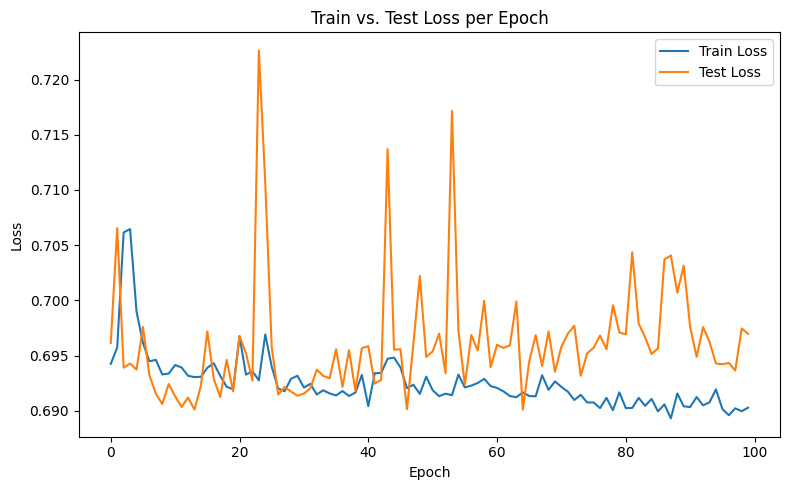

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6820
[Epoch 10/100]  Train Loss: 0.6166
[Epoch 15/100]  Train Loss: 0.5265
[Epoch 20/100]  Train Loss: 0.4582
[Epoch 25/100]  Train Loss: 0.3950
[Epoch 30/100]  Train Loss: 0.3544
[Epoch 35/100]  Train Loss: 0.3511
[Epoch 40/100]  Train Loss: 0.3212
[Epoch 45/100]  Train Loss: 0.2949
[Epoch 50/100]  Train Loss: 0.2804
[Epoch 55/100]  Train Loss: 0.2689
[Epoch 60/100]  Train Loss: 0.2423
[Epoch 65/100]  Train Loss: 0.2533
[Epoch 70/100]  Train Loss: 0.2573
[Epoch 75/100]  Train Loss: 0.2098
[Epoch 80/100]  Train Loss: 0.2393
[Epoch 85/100]  Train Loss: 0.2192
[Epoch 90/100]  Train Loss: 0.1996
[Epoch 95/100]  Train Loss: 0.2092
[Epoch 100/100]  Train Loss: 0.2024
Accuracy on Nonzero Predictions: 0.5439


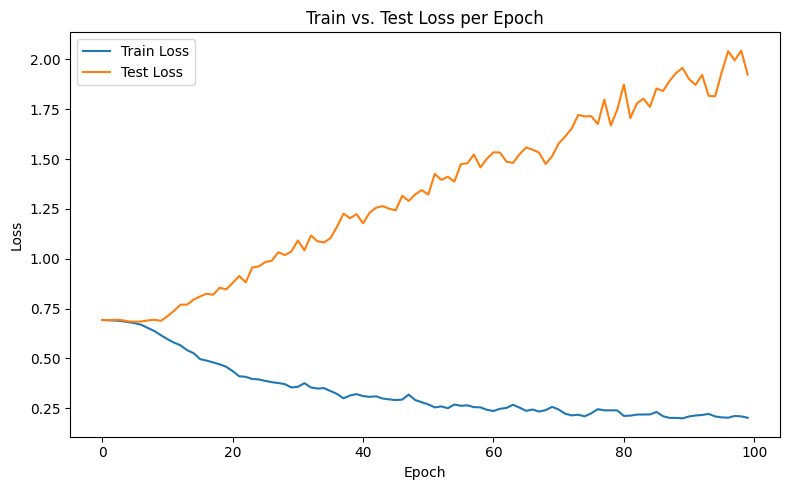

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
Final X shape: (12540, 92, 10)
Final y shape: (12540,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7016
[Epoch 10/100]  Train Loss: 0.6931
[Epoch 15/100]  Train Loss: 0.6934
[Epoch 20/100]  Train Loss: 0.6941
[Epoch 25/100]  Train Loss: 0.6924
[Epoch 30/100]  Train Loss: 0.6921
[Epoch 35/100]  Train Loss: 0.6907
[Epoch 40/100]  Train Loss: 0.6898
[Epoch 45/100]  Train Loss: 0.6911
[Epoch 50/100]  Train Loss: 0.6910
[Epoch 55/100]  Train Loss: 0.6876
[Epoch 60/100]  Train Loss: 0.6878

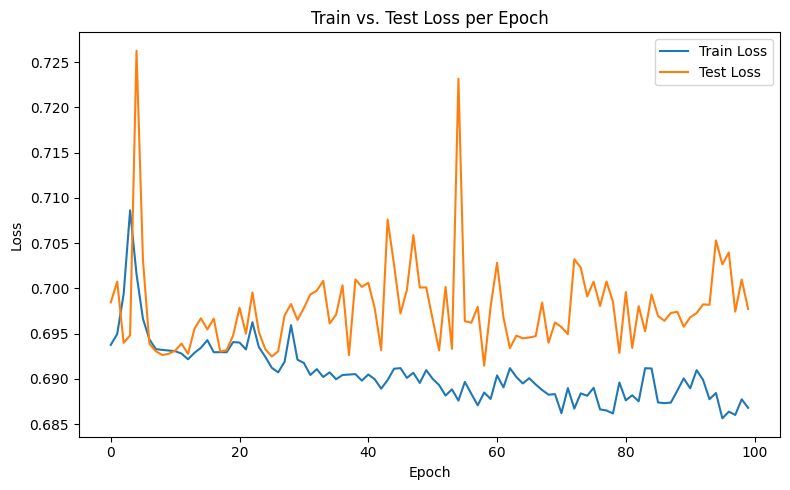

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6825
[Epoch 10/100]  Train Loss: 0.6295
[Epoch 15/100]  Train Loss: 0.5347
[Epoch 20/100]  Train Loss: 0.4445
[Epoch 25/100]  Train Loss: 0.3854
[Epoch 30/100]  Train Loss: 0.3369
[Epoch 35/100]  Train Loss: 0.3351
[Epoch 40/100]  Train Loss: 0.2725
[Epoch 45/100]  Train Loss: 0.2741
[Epoch 50/100]  Train Loss: 0.2700
[Epoch 55/100]  Train Loss: 0.2530
[Epoch 60/100]  Train Loss: 0.2494
[Epoch 65/100]  Train Loss: 0.2331
[Epoch 70/100]  Train Loss: 0.2284
[Epoch 75/100]  Train Loss: 0.2109
[Epoch 80/100]  Train Loss: 0.2106
[Epoch 85/100]  Train Loss: 0.2083
[Epoch 90/100]  Train Loss: 0.2111
[Epoch 95/100]  Train Loss: 0.1892
[Epoch 100/100]  Train Loss: 0.2075
Accuracy on Nonzero Predictions: 0.5407


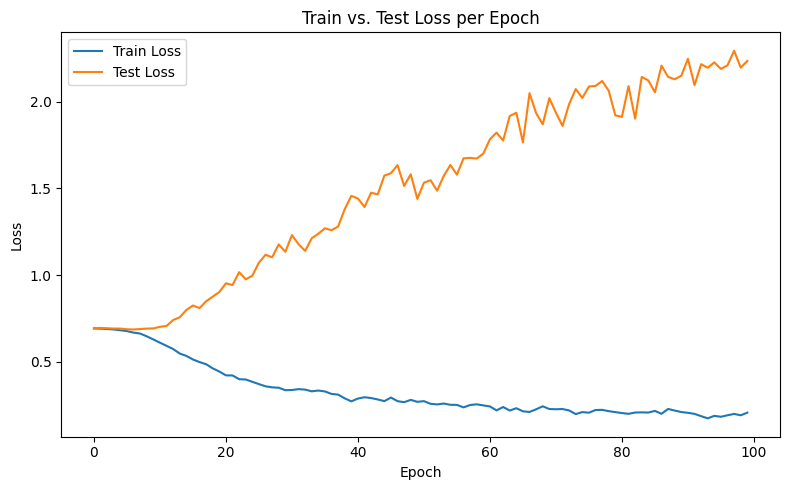

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
Final X shape: (12540, 92, 10)
Final y shape: (12540,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6980
[Epoch 10/100]  Train Loss: 0.6938
[Epoch 15/100]  Train Loss: 0.6931
[Epoch 20/100]  Train Loss: 0.6953
[Epoch 25/100]  Train Loss: 0.6928
[Epoch 30/100]  Train Loss: 0.6933
[Epoch 35/100]  Train Loss: 0.6924
[Epoch 40/100]  Train Loss: 0.6926
[Epoch 45/100]  Train Loss: 0.6917
[Epoch 50/100]  Train Loss: 0.6912
[Epoch 55/100]  Train Loss: 0.6895
[Epoch 60/100]  Train Loss: 0.6903

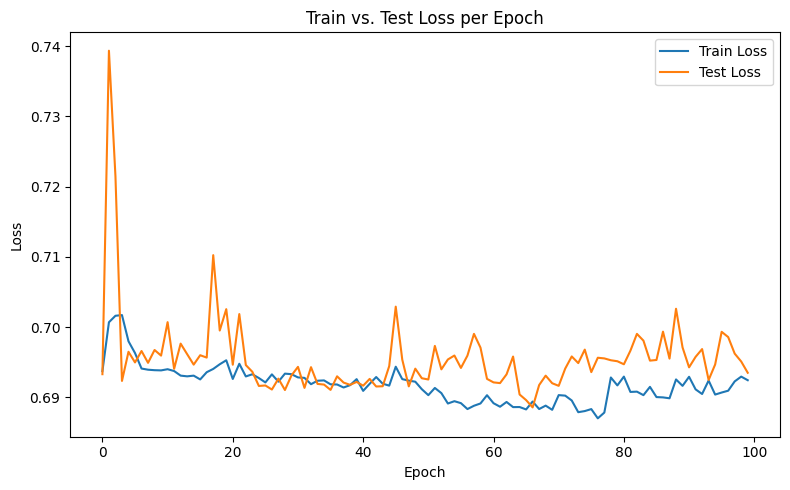

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6829
[Epoch 10/100]  Train Loss: 0.6214
[Epoch 15/100]  Train Loss: 0.5241
[Epoch 20/100]  Train Loss: 0.4508
[Epoch 25/100]  Train Loss: 0.3979
[Epoch 30/100]  Train Loss: 0.3409
[Epoch 35/100]  Train Loss: 0.3414
[Epoch 40/100]  Train Loss: 0.3033
[Epoch 45/100]  Train Loss: 0.2720
[Epoch 50/100]  Train Loss: 0.2812
[Epoch 55/100]  Train Loss: 0.2700
[Epoch 60/100]  Train Loss: 0.2468
[Epoch 65/100]  Train Loss: 0.2271
[Epoch 70/100]  Train Loss: 0.2334
[Epoch 75/100]  Train Loss: 0.2273
[Epoch 80/100]  Train Loss: 0.2275
[Epoch 85/100]  Train Loss: 0.2320
[Epoch 90/100]  Train Loss: 0.2049
[Epoch 95/100]  Train Loss: 0.2181
[Epoch 100/100]  Train Loss: 0.2260
Accuracy on Nonzero Predictions: 0.5088


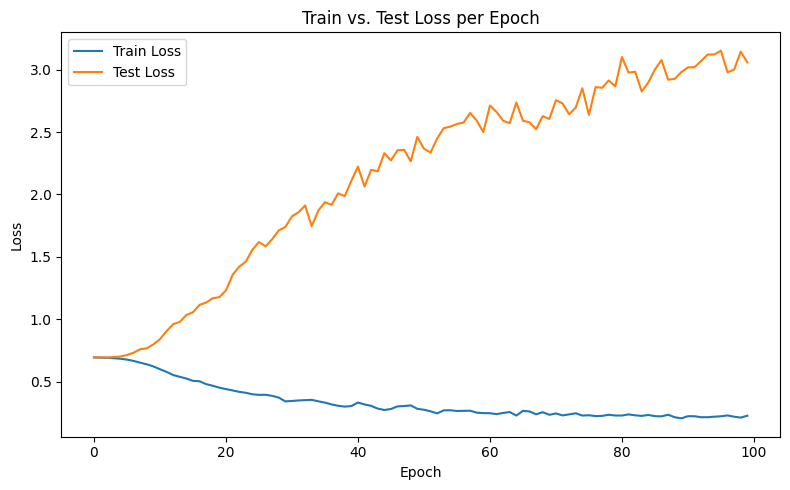

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
Final X shape: (12540, 92, 10)
Final y shape: (12540,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6961
[Epoch 10/100]  Train Loss: 0.6942
[Epoch 15/100]  Train Loss: 0.6935
[Epoch 20/100]  Train Loss: 0.6929
[Epoch 25/100]  Train Loss: 0.6919
[Epoch 30/100]  Train Loss: 0.6929
[Epoch 35/100]  Train Loss: 0.6919
[Epoch 40/100]  Train Loss: 0.6913
[Epoch 45/100]  Train Loss: 0.6917
[Epoch 50/100]  Train Loss: 0.6905
[Epoch 55/100]  Train Loss: 0.6896
[Epoch 60/100]  Train Loss: 0.6887

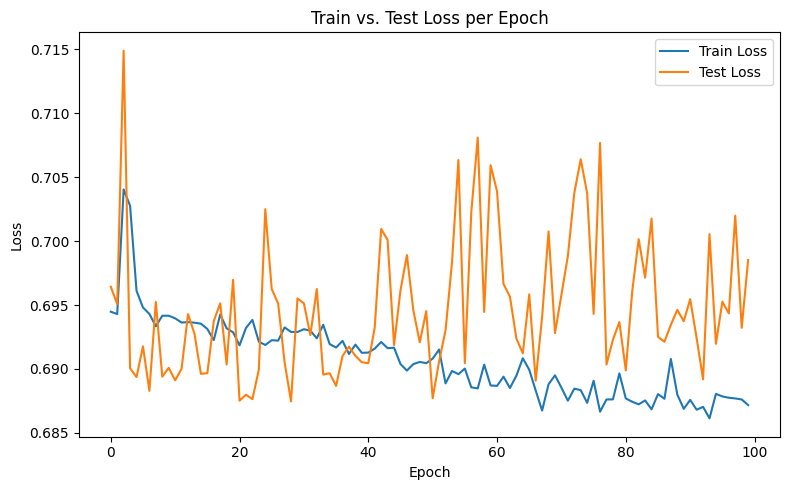

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6798
[Epoch 10/100]  Train Loss: 0.6163
[Epoch 15/100]  Train Loss: 0.5319
[Epoch 20/100]  Train Loss: 0.4721
[Epoch 25/100]  Train Loss: 0.4062
[Epoch 30/100]  Train Loss: 0.3745
[Epoch 35/100]  Train Loss: 0.3444
[Epoch 40/100]  Train Loss: 0.3178
[Epoch 45/100]  Train Loss: 0.3048
[Epoch 50/100]  Train Loss: 0.2799
[Epoch 55/100]  Train Loss: 0.2905
[Epoch 60/100]  Train Loss: 0.2778
[Epoch 65/100]  Train Loss: 0.2685
[Epoch 70/100]  Train Loss: 0.2568
[Epoch 75/100]  Train Loss: 0.2520
[Epoch 80/100]  Train Loss: 0.2517
[Epoch 85/100]  Train Loss: 0.2417
[Epoch 90/100]  Train Loss: 0.2540
[Epoch 95/100]  Train Loss: 0.2504
[Epoch 100/100]  Train Loss: 0.2465
Accuracy on Nonzero Predictions: 0.5279


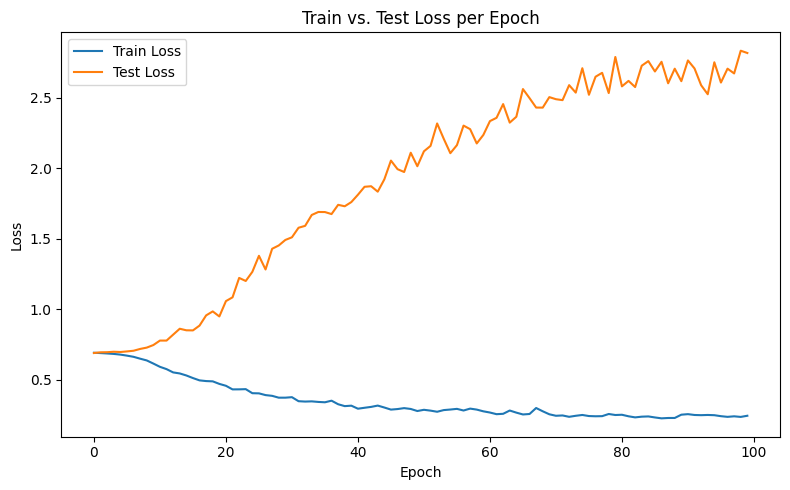

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
Final X shape: (12540, 92, 10)
Final y shape: (12540,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7385
[Epoch 10/100]  Train Loss: 0.7095
[Epoch 15/100]  Train Loss: 0.7068
[Epoch 20/100]  Train Loss: 0.7058
[Epoch 25/100]  Train Loss: 0.7049
[Epoch 30/100]  Train Loss: 0.7044
[Epoch 35/100]  Train Loss: 0.7038
[Epoch 40/100]  Train Loss: 0.7038
[Epoch 45/100]  Train Loss: 0.7035
[Epoch 50/100]  Train Loss: 0.7025
[Epoch 55/100]  Train Loss: 0.7023
[Epoch 60/100]  Train Loss: 0.6995

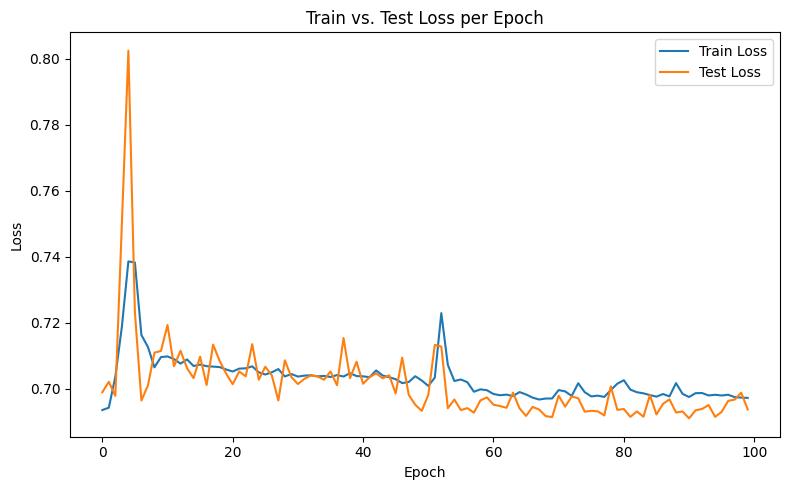

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6809
[Epoch 10/100]  Train Loss: 0.6218
[Epoch 15/100]  Train Loss: 0.5268
[Epoch 20/100]  Train Loss: 0.4425
[Epoch 25/100]  Train Loss: 0.4122
[Epoch 30/100]  Train Loss: 0.3776
[Epoch 35/100]  Train Loss: 0.3479
[Epoch 40/100]  Train Loss: 0.3147
[Epoch 45/100]  Train Loss: 0.2804
[Epoch 50/100]  Train Loss: 0.2931
[Epoch 55/100]  Train Loss: 0.3017
[Epoch 60/100]  Train Loss: 0.2577
[Epoch 65/100]  Train Loss: 0.2814
[Epoch 70/100]  Train Loss: 0.2407
[Epoch 75/100]  Train Loss: 0.2492
[Epoch 80/100]  Train Loss: 0.2312
[Epoch 85/100]  Train Loss: 0.2520
[Epoch 90/100]  Train Loss: 0.2552
[Epoch 95/100]  Train Loss: 0.2250
[Epoch 100/100]  Train Loss: 0.2340
Accuracy on Nonzero Predictions: 0.5486


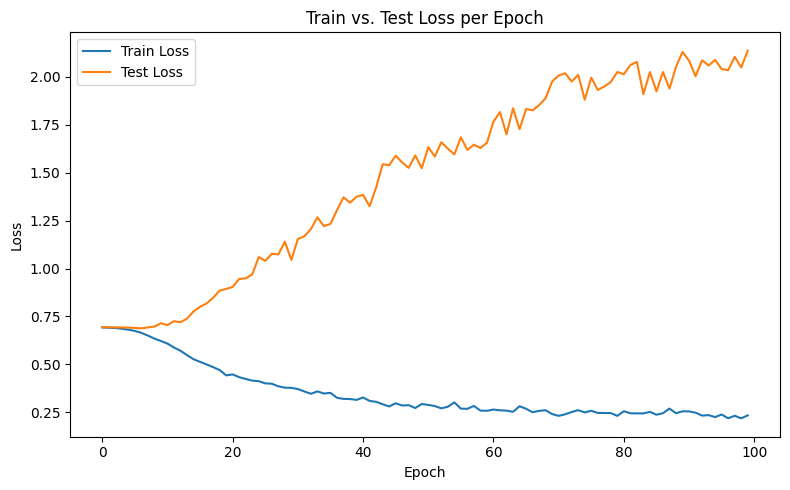

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png


In [30]:
model_types = ["gru", "lstm"]
window_sizes = [5, 10, 50, 100]
window_size = 10
test_size = 300

results_list = []

for stock in stocks:
    stock_list = move_to_last(stocks, stock)
    
    X_combined, y_combined = combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stock_list, test_size)
    input_size = X_combined.shape[2]
    # train_size = int(X_combined.shape[0] * possible_train_size / 100)
    train_size = X_combined.shape[0] - test_size
    # test_size = X_combined.shape[0] - train_size

    for model_type in model_types:
        if model_type == "gru":
            model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
        elif model_type == "lstm":
            model = StockPriceLSTM(input_size, hidden_size, output_size)

        model = model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
              f"| Batch: {batch_size} | Security type: {security_type}")


        result = evaluate_model_plot(
            model, 
            X_combined, 
            y_combined, 
            criterion, 
            optimizer, 
            device, 
            train_size, 
            batch_size, 
            num_epochs, 
            lower_threshold = 0.5,
            plots_dir=plots_dir,
            plot_filename=None
        )

        # Store results in a list
        results_list.append({
            "stock": stock,
            "security_type": security_type,
            "window_size": window_size,
            "model_type": model_type,
            "accuracy_nonzero": result["accuracy_nonzero"],
            "loss_decrease_percentage": result["loss_decrease_percentage"],
            "final_train_loss": result["final_train_loss"]
        })

results_df = pd.DataFrame(results_list)

In [32]:
output_folder = os.path.join(results_dir, 'combined_vs_individual')

results_df.to_csv(os.path.join(output_folder, f'combined_technical_{window_size}.csv'), index=False)

In [31]:
results_df

,stock,security_type,window_size,model_type,iteration,accuracy_nonzero,loss_decrease_percentage,final_train_loss
0,AAPL,technical,5,gru,1,0.520593,2.876113,0.688173
1,AAPL,technical,5,gru,2,0.485997,3.133070,0.693890
2,AAPL,technical,5,gru,3,0.487644,2.183363,0.684965
3,AAPL,technical,5,gru,4,0.500824,1.894274,0.682196
4,AAPL,technical,5,gru,5,0.466227,9.281051,0.729647
5,AMZN,technical,5,gru,1,0.482702,1.556187,0.690572
6,AMZN,technical,5,gru,2,0.514003,2.376356,0.685718
7,AMZN,technical,5,gru,3,0.481054,2.548959,0.687634
8,AMZN,technical,5,gru,4,0.497529,5.115562,0.701124
9,AMZN,technical,5,gru,5,0.500824,4.296588,0.695367
